In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

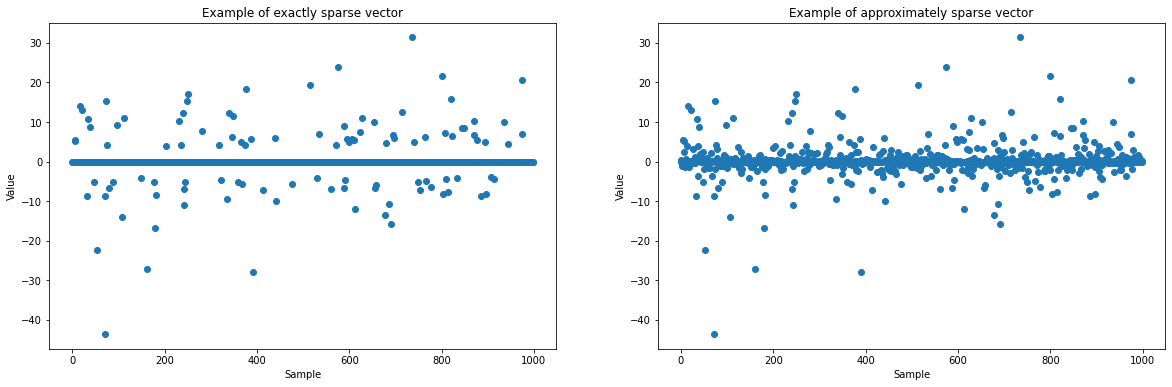

In [2]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

**1)** What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

A signal is exacly sparse if only a small part (k elements) of it is not equal to zero: $||\textbf{s}||_0 = k \ll t$, with the pseudo-norm || . || being the cardinal of the support of $\textbf{s}$. Most real-life signals are not exactly sparse: $||\textbf{s}||_0 \approx t$, being approximately sparse sginals that occurr when only a small number k of the signal samples have a large amplitude.

**2)** Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

We can see that the scatter plot of the sources has a star shape, due to the sparsity of the data. Since there are few high values for both components, the chance that a point is high in both axis is really low, while the chances of being close to zero in one or the two of them is high.

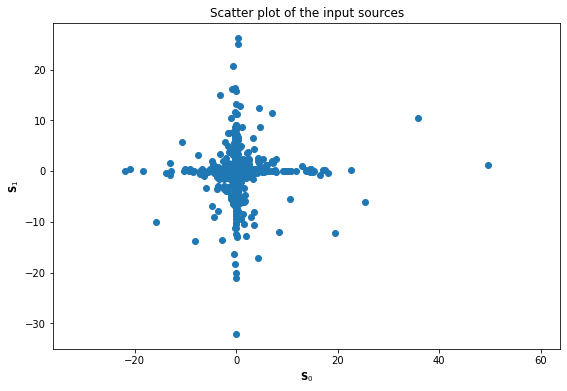

In [3]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 80 # noise level, in dB
power = 3 # power exponent used in the source generation

# TO DO : generate a simulated source S matrix. 
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse 
# law we used above.
S = np.zeros((n,t)) # TO CHANGE

for i in range(S.shape[0]):
  S[i,:] = np.random.randn(t)**power 

# TO DO : interpret the shape of the scatter plot you obtain
fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

In [4]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S  
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

noise_level = 400 

# To be more realistic, we add some noise to the mixing. 
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120: 
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

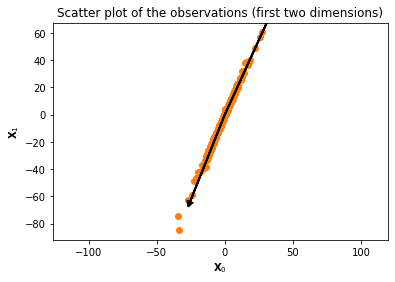

In [5]:
# TO DO : plot the scatter plot of X. What do you see ? 
# What do the directions of the lines you observe correspond ?
# Try several A matrices, noise_values and powers. Note your comments.

plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

Multiplying the sources by $\textbf{A}$ changes the direction of the axes, which correspond to the two directions of more variability in our data.

We can also see that changing the matrix A will modify the directions of the axes, that a small *noise_level* makes S0 and S1 indestinguishable, but higher values allow them to be clearly separable and that using a even number for the power will result in a L shape (all positive values).


**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

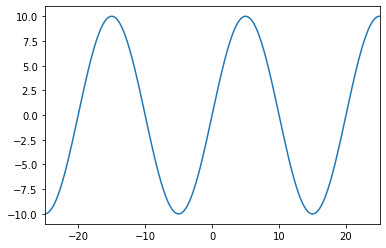

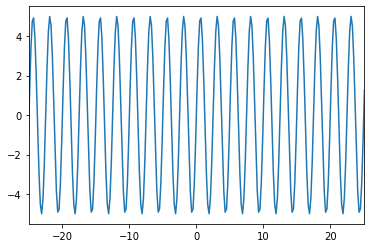

In [6]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

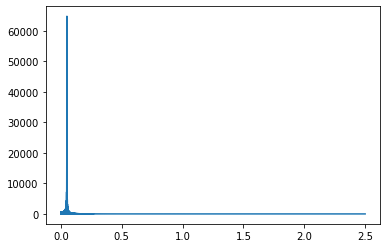

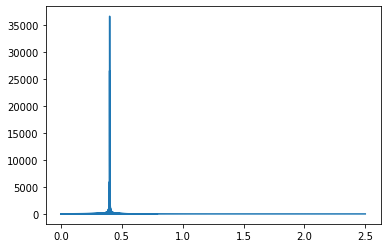

In [7]:
# Transformation into the DCT domain
Sf = sff.dct(S)

# TO DO : what is the objective of using the DCT?
# TO DO : plot the above DCT and justify what you see? Pay attention to the labeling of the x-axis. Try with sinus of various frequencies.
plt.figure()
plt.plot(np.linspace(0,2.5,t), np.abs(Sf[0]))


plt.figure()
plt.plot(np.linspace(0,2.5,t), np.abs(Sf[1]))

Using the DCT allows us to visualise the peaks in the frequency from each signal and be able to separate them.

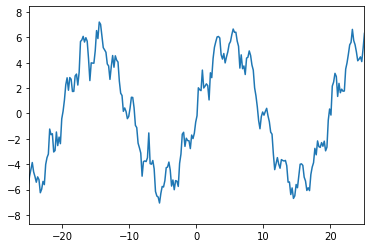

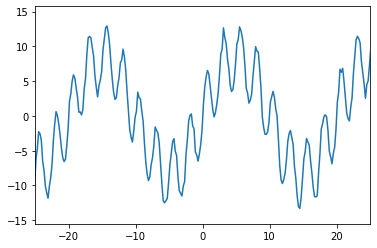

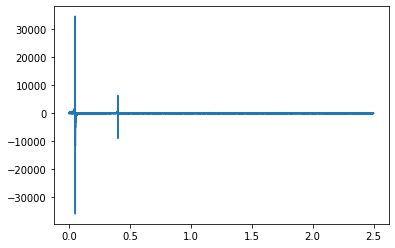

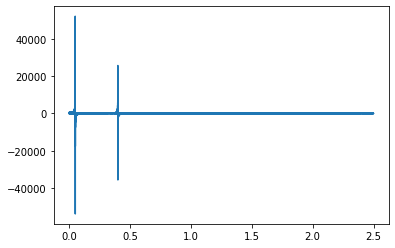

In [8]:
# Data generation : now, we will create a mixture X = AS + N
A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A value, but the columns must have a unitary norm.

X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values

# TO DO : plot the mixtures. Explain what you see.
plt.figure()
plt.plot(x_abs, X[0,:])
plt.xlim([-25,25])

plt.figure()
plt.plot(x_abs, X[1,:])
plt.xlim([-25,25])

# TO DO : compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

Xf = sff.dct(X)

plt.figure()
plt.plot(np.linspace(0,2.5,t), Xf[0])

plt.figure()
plt.plot(np.linspace(0,2.5,t), Xf[1])

We can see that both graphs are noisy sine functions, due to the multiplication of S and A that is similar to the result of a sum of sines.

In the DCT domain, we can still verify the sparse property of the sources that causes peaks that allows us to recover the sources.

**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

**2-1)** First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?


The cost function is given by:

$$argmin_{A \in \mathbb{R}^{m \times n}, S \in \mathbb{R}^{n \times t}}\frac{1}{2}||X-AS||^2_F +\lambda||S||_1$$

The first term corresponds to the Data-fidelity and is smooth and differentiable. The second represents the Sparsity and is not differentiable or smooth.

This function is convex.

**2-2)** Compute the gradient along the S variable of the data-fidelity term.

The gradient along the S variable of the data-fidelity term is: $$\nabla f(S^{(k)}) = A^T(AS-X)$$


**2-3)** Recall what the proximal operator of the l1-norm is.

The proximal operator of the $l_1$ norm is the soft-thresholding operator:

$(prox_{\lambda |.||_1}(v))_i  =  \begin{cases} 
      v_i-\lambda &, v_i \ge \lambda \\
      0 &, |v_i|\  \le \lambda \\
      v_i+\lambda &, v_i \le -\lambda
\end{cases}$

In [20]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
def prox_l1(S_est,thrd):
  S_est = np.sign(S_est)*np.maximum(np.abs(S_est)-thrd, 0.)
  
  return S_est

**2-4)** In your report, explain the main idea of the ISTA algorithm. Then, implement it.

In [21]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X, A = np.eye(2), n=2, lamb=0, nbIt = 100):
  S_est = np.zeros((A.shape[1], X.shape[1]))
  gamma = 0.9/np.linalg.norm(A.T@A)

  for i in range(nbIt):
    S_est = prox_l1(S_est + gamma * A.T@(X-A@S_est), lamb) 

  return S_est

**2-5)** It's now time to play with the code : launch the ISTA algorithm and look at the results.

In [22]:
S_estf = ISTA(Xf,A = A,n=2,lamb=1000,nbIt = 1000)# TO DO : try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?

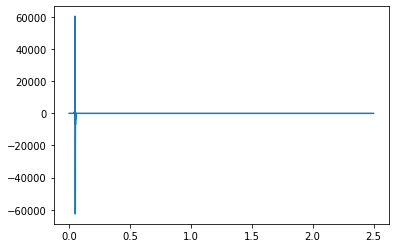

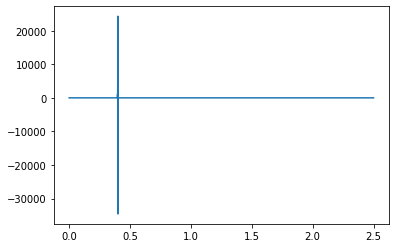

In [23]:
# Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?
plt.figure()
plt.plot(np.linspace(0,2.5,t), (S_estf[0]))

plt.figure()
plt.plot(np.linspace(0,2.5,t), (S_estf[1]))

The minimum value we should not go below when defining $\lambda$ is zero because hen the value is small there is no constraint on the sparity of the sources. If we increase $\lambda$ we will also increase the regularization, which can cause a problem because more signal is lost.


**2-6)** Transform the sources back in the direct domain. What do you see? Conclude.

(-25.0, 25.0)

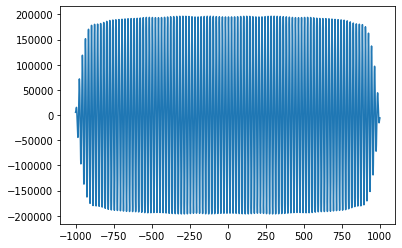

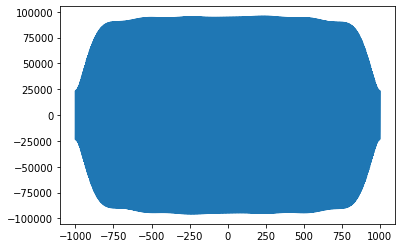

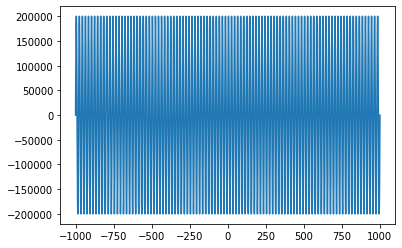

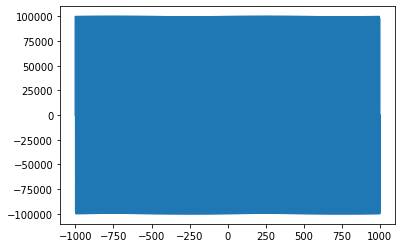

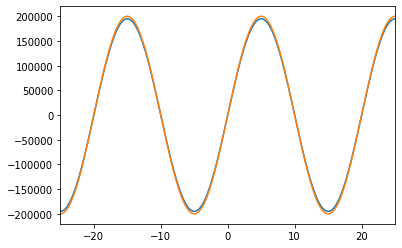

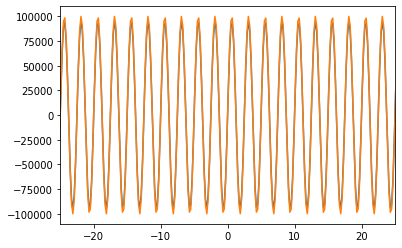

In [24]:
# TO DO : transform the estimated sources in the direct domain? Plot them. Explain the differences with the original sources you observe.
Sf = sff.idct(S_estf) 

# TO DO : compare the central parts of the original and estimated sources.
plt.figure()
plt.plot(x_abs, Sf[0])

plt.figure()
plt.plot(x_abs, Sf[1])

plt.figure()
plt.plot(x_abs, S[0]*20000)

plt.figure()
plt.plot(x_abs, S[1]*20000)

plt.figure()
plt.plot(x_abs, Sf[0])
plt.plot(x_abs, S[0]*20000)
plt.xlim([-25,25])

plt.figure()
plt.plot(x_abs, Sf[1])
plt.plot(x_abs, S[1]*20000)
plt.xlim([-25,25])


We can notice that the results are really similar to the original sinus signals from the ISTA estimation, even if we have to multiply S to obtain the same amplitude as Sf.

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

1) Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?




The cost function is given by:
$$argmin_{A \in \mathbb{R}^{m \times n},S \in \mathbb{R}^{n \times t}}\frac{1}{2}||X-AS||^2_F +\lambda||S||_1+\iota_{\{\forall i \in [1,n];||a_{:,j}||^2_{l_2}\le1\}}(A)$$

where the first term is the Data-fidelity, the second is the Sparsity and the third the oblique constraint.

This function is non-smooth and also non-convex.

2) Recall what the gradient of the data fidelity term over A is.

The gradient of the data fidelity term over A is:

$$\nabla f(S^{(k)}) = (AS-X)S^T$$

3) Compte the proximal operator of the oblique constraint. Implement it.

In [33]:
def prox_oblique(A):
   # TO DO    
  for j in range(A.shape[1]):
    A[:, j] = A[:, j]/max(1, np.linalg.norm(A[:, j]))    
  return A

4) Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [34]:
def PALM(X,n=2,lamb=0,nbIt = 100):
   # TO DO
    S_est = np.zeros((n, X.shape[1]))
    A_est = np.eye(X.shape[0],n)
 
    for i in range(nbIt):
      S_est = prox_l1(S_est + (0.9/(np.linalg.norm(A_est.T @ A_est)+1e-10))*((A_est.T @ (X-(A_est @ S_est)))), lamb)
      A_est = prox_oblique(A_est + (0.9/(np.linalg.norm(S_est @ S_est.T)+1e-10)) * (X-(A_est@S_est))@(S_est.T))

    return A_est, S_est

5) Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

(-25.0, 25.0)

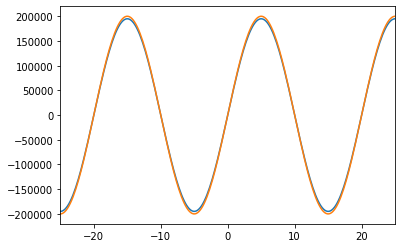

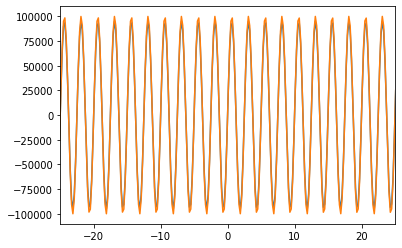

In [35]:
A_fest, S_fest = PALM(Xf, n=2, lamb=1000, nbIt=1000)
S_fest = sff.idct(S_fest)

plt.figure()
plt.plot(x_abs, S_fest[0])
plt.plot(x_abs,200000*np.sin(2*np.pi*0.05*x_abs))
plt.xlim([-25,25])

plt.figure()
plt.plot(x_abs, S_fest[1])
plt.plot(x_abs,100000*np.sin(2*np.pi*0.4*x_abs))
plt.xlim([-25,25])

In [36]:
print('Matrix A:', A)
print('Matrix A_est: ', A_fest)

Matrix A: [[0.5547002  0.24253563]
 [0.83205029 0.9701425 ]]
Matrix A_est:  [[0.55397115 0.24218908]
 [0.83253587 0.97022907]]


We can see both from the graph and the matrixes that the results were good and that we can separate the signals.